## Automated search for class identification threshold values in the case of Artificial Neural Networks

In this project we're dealing with a binary classification problem. We already have baseline scores having run classifiers from the sklearn suite on the dataset. What we're trying to do here is to see if we can do better than the scores resulting from the out of the box Python ML algorithms (Decision Tree, Random Forest, NeuralNet, AdaBoost, XGBoost).

The metric of interest for us is the number of false negatives. We're trying to keep that as low as possible. So this will become an exercise in answering the question *what is an appropriate metric from a business case pov?* We want to optimize our model to the business problem at hand and not to some out of the box, academic metrics.

The second issue of interest here is how flexible the artificial neural network construct is in adapting to the problem at hand compared to the competing out of the box Python ML algorithms (Decision Tree, Random Forest, NeuralNet, AdaBoost, XGBoost), being both *business case* accurate (not in the accuracy metrics sense, we're not solving for accuracy) and in the generalizing power (that of not being overfit on the training set and poor on unseen data).


#### Business Problem

The Customer Engagement group uses leads provided by Sales to engage with prospective clients. The issue is the conversion rate is low. The business problem is one of cost control: how to keep adequate staffing levels in the customer engagement group? Low conversion rate translates to low productivity. To increase the productivity we need to increase the ratio of customers to staff. Being able to filter out the false prospective customers will be the first step on that road. This is the classification problem we're tackling in this project

In [53]:
# import the libraries
import eli5 # experimental library: pip install eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

from keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')

import numpy as np
from sklearn.utils import shuffle
from numpy import array
from numpy import count_nonzero

# For keras
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers

# For metrics
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Confusion matrix and classification reports
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Data ingestion

There are cases when data ingestion doesn't go smoothly. Here we're doing a preliminary check on the encoding

In [ ]:
import chardet # only for CSV file
path = 'TenantReduced4.csv'

# checking the encoding
with open(path, 'rb') as data:
    result = chardet.detect(data.read(1000))
print(result)

In [54]:
# reading the csv
df = pd.read_csv(path, encoding = 'ascii')
print('Data shape:',df.shape)
df.head()

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
Data shape: (162321, 12)


,TenantId,IsEDU,IsNonProfIt,IsGov,EntitlementSeatBucket,TopParentsCount,FinalIndustry,FinalVertical,ServiceName,TenantAgeBucket,Country,BInaryUser
0,746f7b08-a7f8-47c0-a63c-819f3f0cdef8,0,0,0,Unknown,1,Unknown,Unknown,Unknown,Unknown,Japan,0
1,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,3.50-149,2,ChemIcals & AgrochemIcals,ChemIcals,SharePoInt,365+,CzechRepublIc,1
2,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,4.150-249,2,ChemIcals & AgrochemIcals,ChemIcals,SfB(Skype for BusIness),365+,CzechRepublIc,1
3,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,1.0-9,2,ChemIcals & AgrochemIcals,ChemIcals,Exchange,365+,CzechRepublIc,1
4,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,4.150-249,2,ChemIcals & AgrochemIcals,ChemIcals,Teams,365+,CzechRepublIc,1


### Data transformation - categorical to numerical

Since categorical data cannot be processed without being first turned into numerical, we're performing one-hot encoding on the categorical data. 

In [55]:
# separating data from labels
def df_to_data_labels(df):
    data = df.iloc[:, 1:-1] # 1st column is TenantId - not needed
    labels = df.iloc[:,-1]
    
    # categorical columns to dummies
    to_dummies = ['EntitlementSeatBucket','TopParentsCount', 'FinalIndustry', 'FinalVertical', 'ServiceName','TenantAgeBucket', 'Country' ]
    x = pd.get_dummies(data = data, columns = to_dummies)
    columns = x.columns
    
    #removing the headers - keeping only the data
    x0 = x.values 
    y0 = labels.values
    return x0, y0, columns
x0,y0,feature_columns = df_to_data_labels(df)

### Data transformation - train, test split

We're splitting the data three ways:

    - training set
    - validation set
    - testing set

The neural network will be trained on the training set and the performance will be tuned on the validation set. We'll save the information in the data model. We're keeping the testing set for the final test of the model. This way, the information from the first two sets won't leak into the third and we'll have a better representation of the generalizing power of the ensuing classification model.

In [56]:
def train_test(x0,y0):
    # shuffle the data so we're getting the datapoints randomized
    x0, y0 = shuffle(x0,y0)
    print('\nSplitting the data...')
    X_train, X_test, y_train, y_test = train_test_split(x0,y0, test_size = .3, random_state = 42)  
    return  X_train, X_test, y_train, y_test

x0,y0,feature_columns = df_to_data_labels(df) # feature_columns is type <class 'pandas.core.indexes.base.Index'>
X_train, X_test, y_train, y_test = train_test(x0,y0)
X_train, X_Val, y_train, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 42 )

print('\nTraining set:: ', X_train.shape)
print('Validation set: ', X_Val.shape)
print('Testing set: ', X_test.shape)  


Splitting the data...

Training set::  (90899, 364)
Validation set:  (22725, 364)
Testing set:  (48697, 364)


### Data modelling

In [57]:
# ANN specs
epoch = 5
bs = 2500 # batch size
n_cols = x0.shape[1]

#### Create ANN model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2048)              747520    
_________________________________________________________________
dense_22 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dense_23 (Dense)             (None, 20)                20020     
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 63        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 4         
Total params: 2,816,607
Trainable params: 2,816,607
Non-trainable params: 0
_________________________________________________________________
Train on 90899 samples, validate on 22725 samples
Epoch 1/5
90899/90899 [==============================] - 8s 83us/step - loss: 0.32

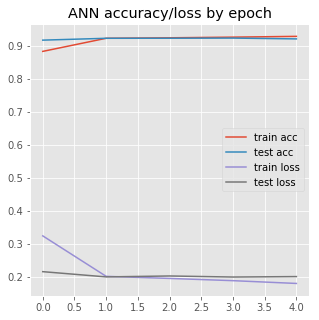

In [58]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

def keras_classifier(x, y, epochs = epoch, batch_size = bs,  validation_data=(X_Val, y_val)):
        
    model = Sequential()
    
    # DENSE LAYERS
    model.add(Dense(2048, activation = 'relu', input_shape = (n_cols,))) 
    model.add(Dense(1000, activation = 'relu')) 
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(3, activation = 'relu')) 
    model.add(Dense(1, activation = 'sigmoid')) 
        
    # COMPILING THE MODEL - OPTIMIZATION
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 
    model.summary()
    r = model.fit(x, y, epochs = epoch, batch_size = bs, validation_data=(X_Val, y_val))
   
    plt.figure(figsize=(5,5))
    plt.plot(r.history['acc'], label='train acc') 
    plt.plot(r.history['val_acc'], label='test acc') 
    plt.plot(r.history['loss'], label='train loss')
    plt.plot(r.history['val_loss'], label='test loss')
    plt.legend()
    plt.title('ANN accuracy/loss by epoch')
    plt.show()
    return model
    
    
clf = keras_classifier(X_train, y_train,  validation_data=(X_Val, y_val))

#### Save the model

In [59]:
# Saving the model
model_name = 'keras_classifier_tenants_shallow0'
    
def model_save(name):
    return clf.save(name)
    
model_save(model_name)
print('model saving complete')

model saving complete


#### Load the model

In [60]:
# Loading the model
model_name = 'keras_classifier_tenants_shallow0'
    
def model_load(name):
    return load_model(name) 
        
clf = model_load(model_name)
print('model loading complete')


model loading complete


### ANN - hyperparameter search

In [61]:
threshold = [.5,.4,.3,.2,.1,.05,.03,.02,.01]

train_fnr = []
test_fnr = []
auc_scores = []
FPR = []
TPR = []


for i in threshold:
    def ANN_Class_Identity():
        
        # Training set
        y_true = y_train
        y_pred = clf.predict(X_train)
        
        y_pred[y_pred < i] = 0 
        y_pred[y_pred >= i] = 1

        cm_train = confusion_matrix(y_train, y_pred)
       
        fn_train = cm_train[1,0]
        train_fnr.append(fn_train)

        # Testing set
        y_true = y_test
        y_pred = clf.predict(X_test)
        
        y_pred[y_pred < i] = 0 
        y_pred[y_pred >= i] = 1

        cm_test = confusion_matrix(y_test, y_pred)
        
        fnr_test = cm_test[1,0]
        test_fnr.append(fnr_test)
        
        # calculate roc curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        FPR.append(fpr)
        TPR.append(tpr)

    ANN_Class_Identity()

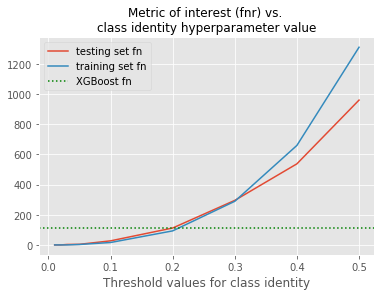

In [62]:
# plot the metric of interest vs threshold hyperparameter values
plt.plot(threshold, test_fnr, label='testing set fn')
plt.plot(threshold, train_fnr, label='training set fn')

plt.title('Metric of interest (fnr) vs. \nclass identity hyperparameter value', fontsize =12)
plt.xlabel('Threshold values for class identity')
plt.axhline(y=114, linestyle=':', color ='g', label='XGBoost fn')
plt.legend()
plt.show()

Training set CONFUSION MATRIX:
 [[35001  8482]
 [    0 47416]] 



Test set CONFUSION MATRIX:
 [[18718  4555]
 [    0 25424]] 


False Negative Accuracy Rate: 100.000 % 




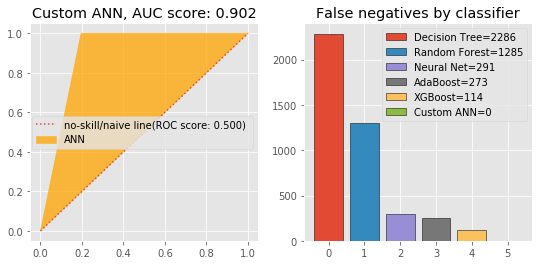

The optimal threshold for class identification is:0.0


In [78]:
# select the index of the lowest false negative number - this is our metric of interest
lowest_fnr = np.argmin(test_fnr)

# select the threshold value corresponding to the lowest number of false negatives
i = threshold[lowest_fnr]

# ANN_Metrics():
    # TRAIN recall, precision, F1 scores 
    
y_true = y_train
y_pred = clf.predict(X_train)
y_pred[y_pred < i] = 0 
y_pred[y_pred >= i] = 1

cm_train = confusion_matrix(y_train, y_pred)
print('Training set CONFUSION MATRIX:\n', cm_train,'\n\n')
fnr_train = cm_train[1,0]
train_fnr.append(fnr_train)

y_true = y_test
y_pred = clf.predict(X_test)
y_pred[y_pred < i] = 0
y_pred[y_pred >= i] = 1

cm_test = confusion_matrix(y_test, y_pred)
print('\nTest set CONFUSION MATRIX:\n', cm_test,'\n\n')  

# False negatives
fnr_test = cm_test[1,0]
test_fnr.append(fnr_test)
sum_all = cm_test.sum()

# True negatives
tnr_test = cm_test[0,1]


# calculate AUC
auc = roc_auc_score(y_test, y_pred)
#print('Test AUC: %.3f' % (auc*100),'%','\n\n')

# calculate new metric - false negative accuracy rate
fnar = (1 - fnr_test/tnr_test)
print('False Negative Accuracy Rate: %.3f' % (fnar*100),'%','\n\n')

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the line of no skill
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title('Custom ANN, AUC score: %.3f'%auc)
plt.plot([0, 1], [0, 1], linestyle=':', label='no-skill/naive line(ROC score: 0.500) ')

# plot the roc curve for the model
plt.fill(fpr, tpr,label = 'ANN', alpha = .75, color = 'orange')#  marker='.', 
#plt.fill(fnr_test, tnr_test,label = 'ANN', alpha = .75, color = 'orange')
plt.legend()

# plot the FN data
plt.subplot(1, 2, 2)
plt.title('False negatives by classifier')
plt.bar(x =0, height = 2286, label = ('Decision Tree' + '=' + str(2286)), edgecolor = 'k')
plt.bar(x =1, height = 1297, label = ('Random Forest' + '=' + str(1285)), edgecolor = 'k')
plt.bar(x =2, height = 291, label = ('Neural Net' + '=' + str(291)), edgecolor = 'k')
plt.bar(x =3, height = 254, label = ('AdaBoost' + '=' + str(273)), edgecolor = 'k')
plt.bar(x =4, height = 114, label = ('XGBoost' + '=' + str(114)), edgecolor = 'k')
plt.bar(x =5, height = fnr_test, label = ('Custom ANN' + '=' + str(fnr_test)), edgecolor = 'k')
plt.legend()
plt.show()

print('The optimal threshold for class identification is:%.1f'%i)

#### Results

The bar chart above represents the different classifier results on the metric of interest (lower is better). We can see that our model easily surpased the runner up XGBoost

The value of the threshold for class identification fluctuates with every iteration of the model. This is why having an automated way to select it is preferable.

### Visualizing the results

Since the dataset is multidimensional, we're perfoming a PCA to reduce its dimensionality from over 300 to 2 dimensions in order to visualize it

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
    
X_train = pca.fit_transform(X_train)
X_Val = pca.fit_transform(X_Val)
X_test = pca.fit_transform(X_test)
        
print('\nTraining set size after dim reduction: ', X_train.shape)
print('Validation set size after dim reduction: ', X_Val.shape)
print('Testing set size after dim reduction: ', X_test.shape)


Training set size after dim reduction:  (90899, 2)
Validation set size after dim reduction:  (22725, 2)
Testing set size after dim reduction:  (48697, 2)



Training the dimensionality reduced sets...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 2048)              6144      
_________________________________________________________________
dense_42 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dense_43 (Dense)             (None, 20)                20020     
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 63        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 4         
Total params: 2,075,231
Trainable params: 2,075,231
Non-trainable params: 0
_________________________________________________________________
Train on 90899 samples, validate on 22725 samples
Epoch 1/2
90899/90899 [=============

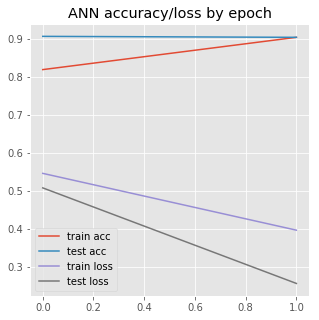

pca model saving complete
model loading complete


In [80]:
# ANN specs
epoch = 2
bs = 2750
n_cols = X_train.shape[1]
        
print('\nTraining the dimensionality reduced sets...\n')
clf = keras_classifier(X_train, y_train,  validation_data=(X_Val, y_val))
        
        
pca_model = 'pca_data_model3'
        
def model_save(name):
    return clf.save(name)
        
model_save(pca_model)
print('pca model saving complete')
        
        
# Loading a model
model_name = 'pca_data_model3'
        
def model_load(name):
    return load_model(name) 
            
clf = model_load(model_name)
print('model loading complete')

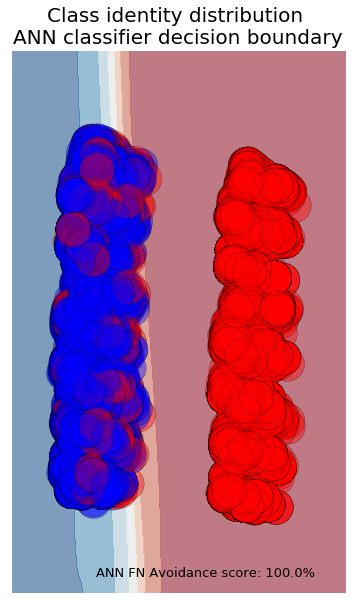

In [91]:
DIA = 1200
        
h = .02  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        
        
# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])#[:, 1]
        
# Put the result into a color plot
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        
plt.figure(figsize = (6, 10))
ax = plt.subplot(111)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.5)
      
    
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=DIA, cmap=cm_bright,edgecolors='k', alpha=0.4)        
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
plt.title('Class identity distribution \nANN classifier decision boundary', fontsize=20)
ax.text(xx.max() - .3, yy.min() + .1, ('ANN FN Avoidance score: %.1f%%' % (fnar*100)).lstrip('0'),
                        size=15, horizontalalignment='right', fontsize=13)
plt.show()

# Conclusion

In this project we have shown the flexibility and customizability or artificial neural networks to deal with specific business needs. In this project, the need was to keep the false negative rate to a minimum. We have also shown how we were able to beat the scores of out of the box ML classification algorithms while preserving the generalizing power of our ANN classifier. 